In [1]:
def plot_n_images(title_image_map, cmap=None):
    cols = 2
    import math
    rows = math.ceil(len(title_image_map) / cols)
    if rows < 1:
        rows = 1

    f, axes = plt.subplots(rows, cols, figsize=(24, 9), squeeze=False)
    #f.tight_layout()
    axes = axes.flatten()
    i = 0
    for title, image in title_image_map.items():
        if cmap == None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image, cmap=cmap)
        axes[i].set_title(title, fontsize=40)
        i = i + 1
        
    plt.subplots_adjust(left=0., right=1, top=2.5, bottom=1.0)

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

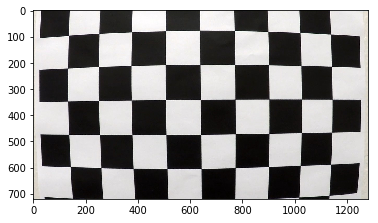

In [3]:
test_image = mpimg.imread("./camera_cal/calibration1.jpg")
plt.imshow(test_image)

In [4]:
object_points = []
image_points = []
nx=9
ny=6
visualize=False
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

import glob
for image_path in glob.glob("./camera_cal/*.jpg"):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_image, (nx, ny), None)

    if ret == True:
        object_points.append(np.copy(objp))
        # this step to refine image points was taken from:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray_image,corners,(11,11),(-1,-1),criteria)
        image_points.append(corners2)

        if visualize: 
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            cv2.imshow("image", image)
            cv2.waitKey(500)
if visualize:
    cv2.destroyAllWindows()

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_size,None,None)
undisitorted = cv2.undistort(img, mtx, dist, None, mtx)
            
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)
    
def warp(image, src, dst):
    h, w = image.shape[:2]

    undistorted_image = undistort(image)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(undistorted_image, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped, undistorted_image, Minv

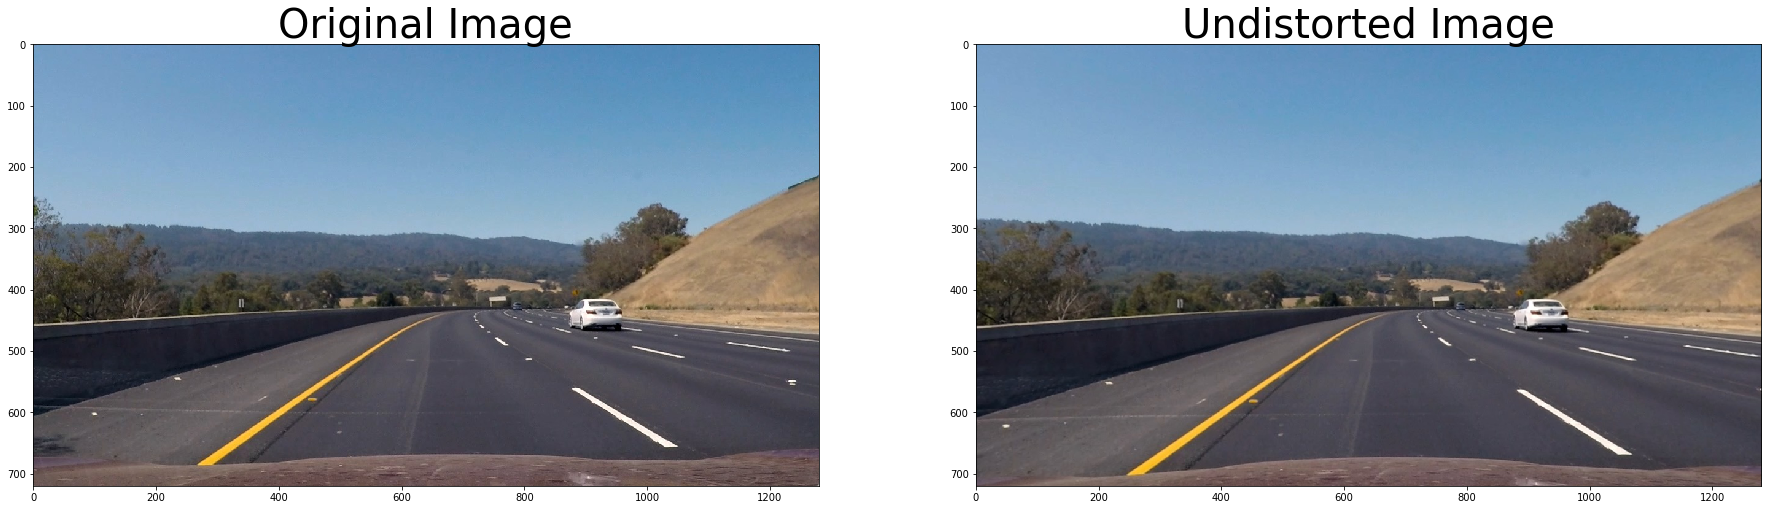

In [5]:
lane_image = cv2.imread("./test_images/test3.jpg")
undistort_map = {}
undistort_map['Original Image'] = lane_image
undistort_map["Undistorted Image"] = undistort(lane_image)
cv2.imwrite('./output_images/Undistorted.jpg', undistort_map["Undistorted Image"])
plot_n_images(undistort_map)

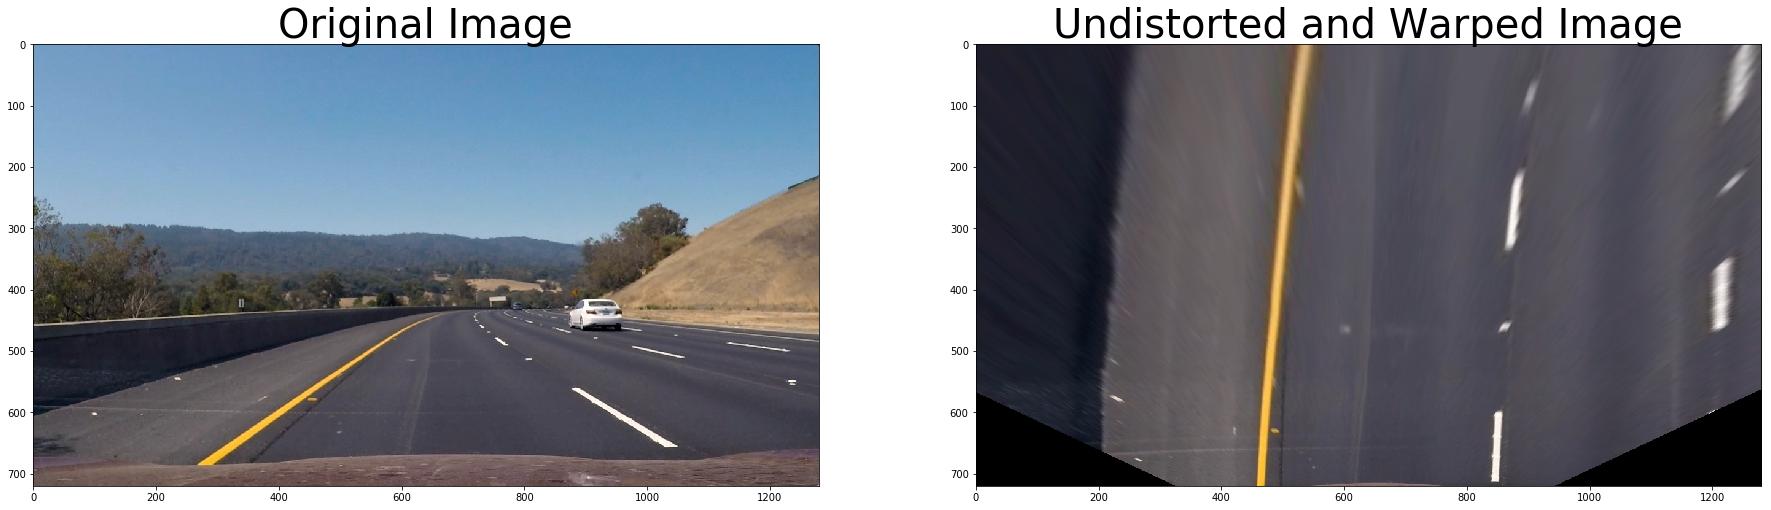

In [6]:
h,w = undistort_map["Undistorted Image"].shape[:2]
# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (830,0),
                  (450,720),
                  (830,720)])

warped_map = {}
warped_map['Original Image'] = lane_image
top_down, _, _ = warp(lane_image, src, dst)
cv2.imwrite('./output_images/Undistorted and Warped Image.jpg', top_down)
warped_map['Undistorted and Warped Image'] = top_down
plot_n_images(warped_map)

In [7]:
def apply_threshold(image, threshold):
    """ Normalizes an image and returns the binary image with the values in the range of the threshold"""
    image = np.uint8(255 * image / np.max(image))
        
    binary_image = np.zeros_like(image)
    binary_image[(image >= threshold[0]) & (image <= threshold[1])] = 1
    
    return binary_image

In [8]:
def apply_sobel(image, orient = 'x', sobel_kernel = 3, threshold = (20, 100)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    return apply_threshold(abs_sobel, threshold)

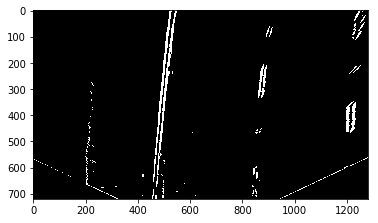

In [9]:
plt.imshow(apply_sobel(top_down), cmap='gray')

In [10]:
def magnitude_threshold(image, sobel_kernel=3, threshold=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
   
    return apply_threshold(gradient_magnitude, threshold)

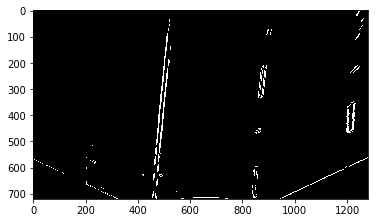

In [11]:
plt.imshow(magnitude_threshold(top_down, 9, (50, 110)), cmap='gray')

In [12]:
def direction_threshold(image, sobel_kernel=3, threshold=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= threshold[0]) & (direction <= threshold[1])] = 1

    return binary_output

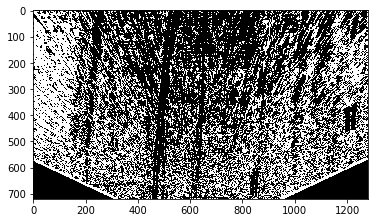

In [13]:
plt.imshow(direction_threshold(top_down, 11, (0.5, 1.3)), cmap='gray')

In [14]:
def combined_threshold(image, ksize = 3):
    # Apply each of the thresholding functions
    gradx = apply_sobel(image, orient='x', sobel_kernel=ksize, threshold=(100, 160))
    grady = apply_sobel(image, orient='y', sobel_kernel=ksize, threshold=(100, 160))
    mag_binary = magnitude_threshold(image, sobel_kernel=ksize, threshold=(100, 160))
    dir_binary = direction_threshold(image, sobel_kernel=ksize, threshold=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | (mag_binary == 1)] = 1

    return combined

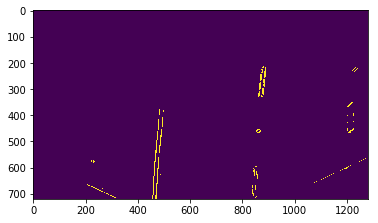

In [15]:
plt.imshow(combined_threshold(top_down, 19))

In [16]:
def channel_threshold(work_image, threshold, selected_channel):
    binary_selected = np.zeros_like(work_image[:,:,selected_channel])
    binary_selected[(work_image[:,:,selected_channel] >= threshold[0]) & 
                    (work_image[:,:,selected_channel] <= threshold[1])] = 1
    
    return binary_selected

def inspect_color_space(image, threshold, conversion=None, selected_channel=0):
    dict_normal = {}
    dict_binary = {}
    if conversion != None:
        work_image = cv2.cvtColor(image, conversion)
    else:
        work_image = np.copy(image)
    
    dict_normal["Original"]  = work_image
    dict_normal["Channel 0"] = work_image[:,:,0]
    dict_normal["Channel 1"] = work_image[:,:,1]
    dict_normal["Channel 2"] = work_image[:,:,2]
    
    gray = cv2.cvtColor(work_image, cv2.COLOR_RGB2GRAY)
    binary_orig = np.zeros_like(gray)
    binary_orig[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    
    binary_selected = channel_threshold(work_image, threshold, selected_channel)
    
    dict_binary["Binary Original"] = binary_orig
    dict_binary["Binary Selected"] = binary_selected
    
    plot_n_images(dict_normal, "gray")
    plot_n_images(dict_binary, "gray")
    
    return binary_selected

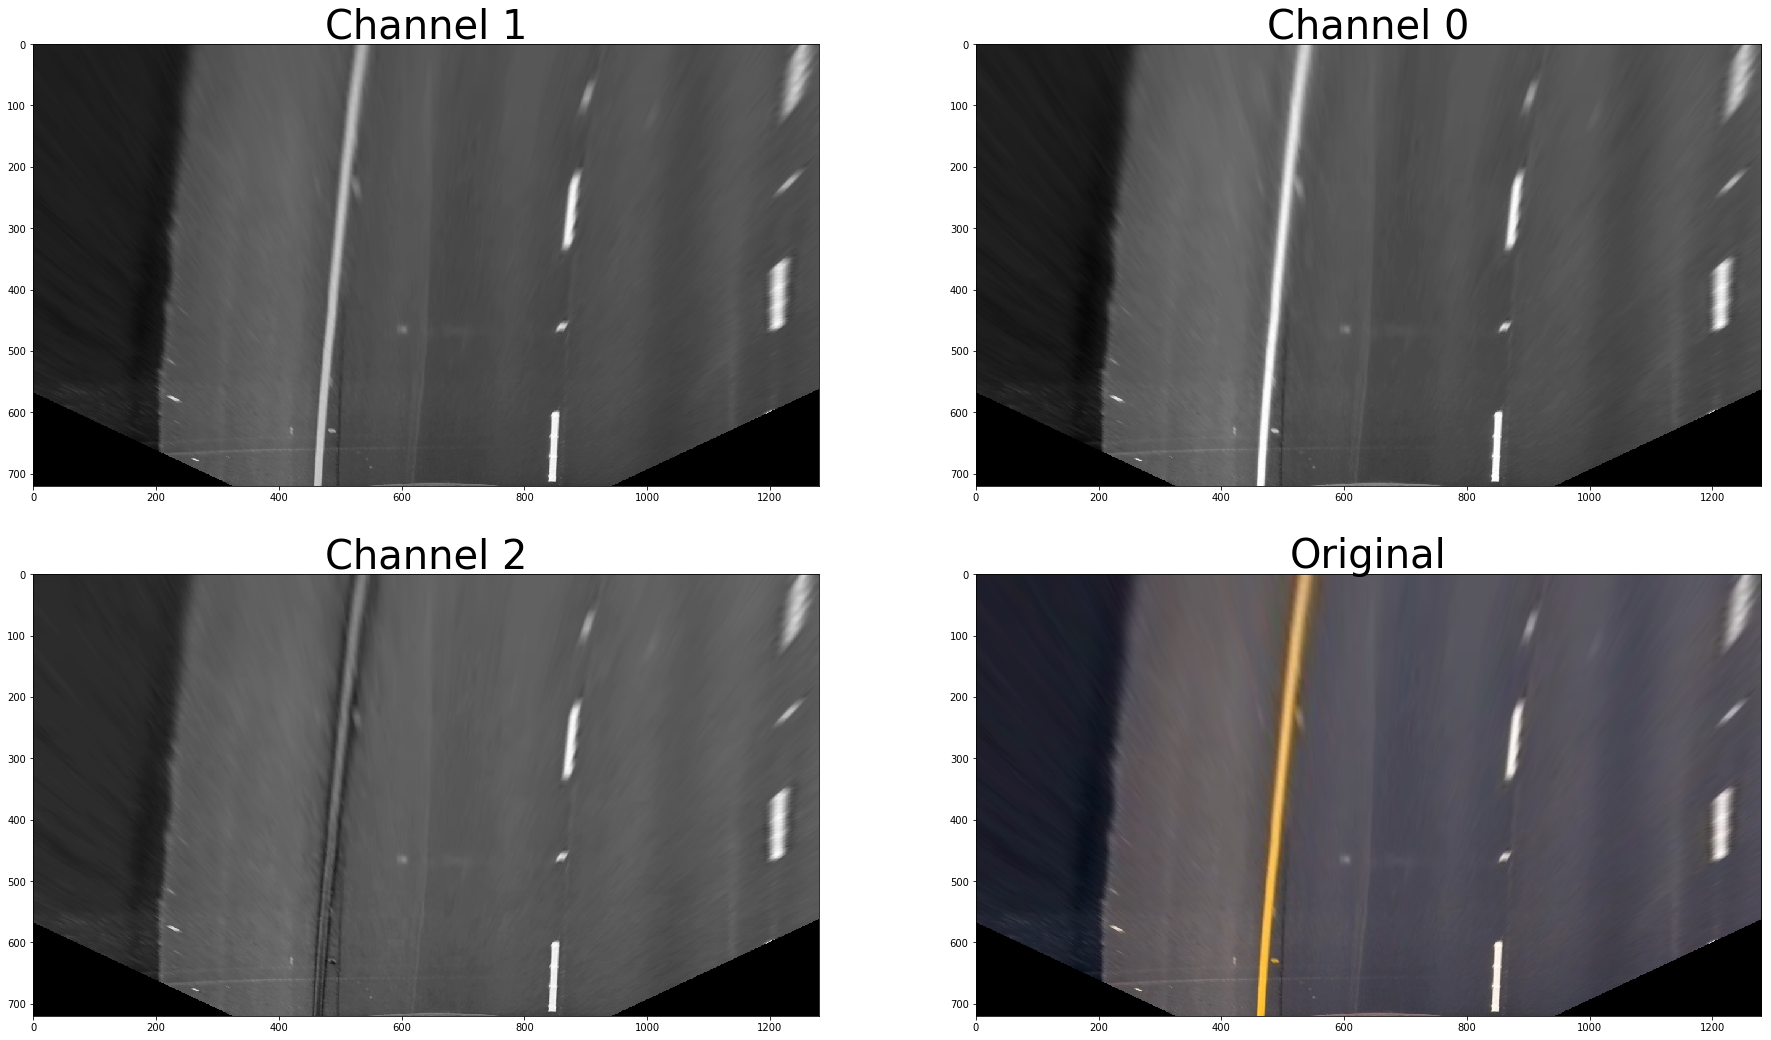

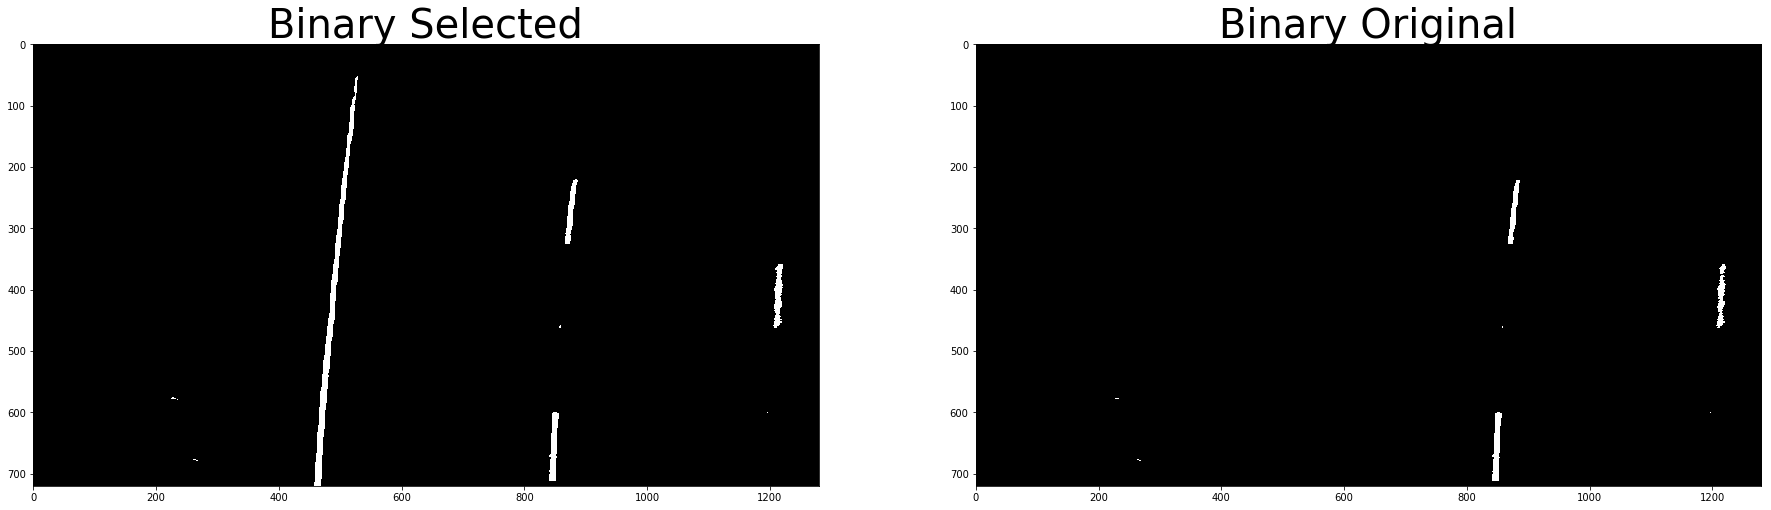

In [17]:
binary_r = inspect_color_space(top_down, threshold=(220, 255), conversion=cv2.COLOR_BGR2RGB)

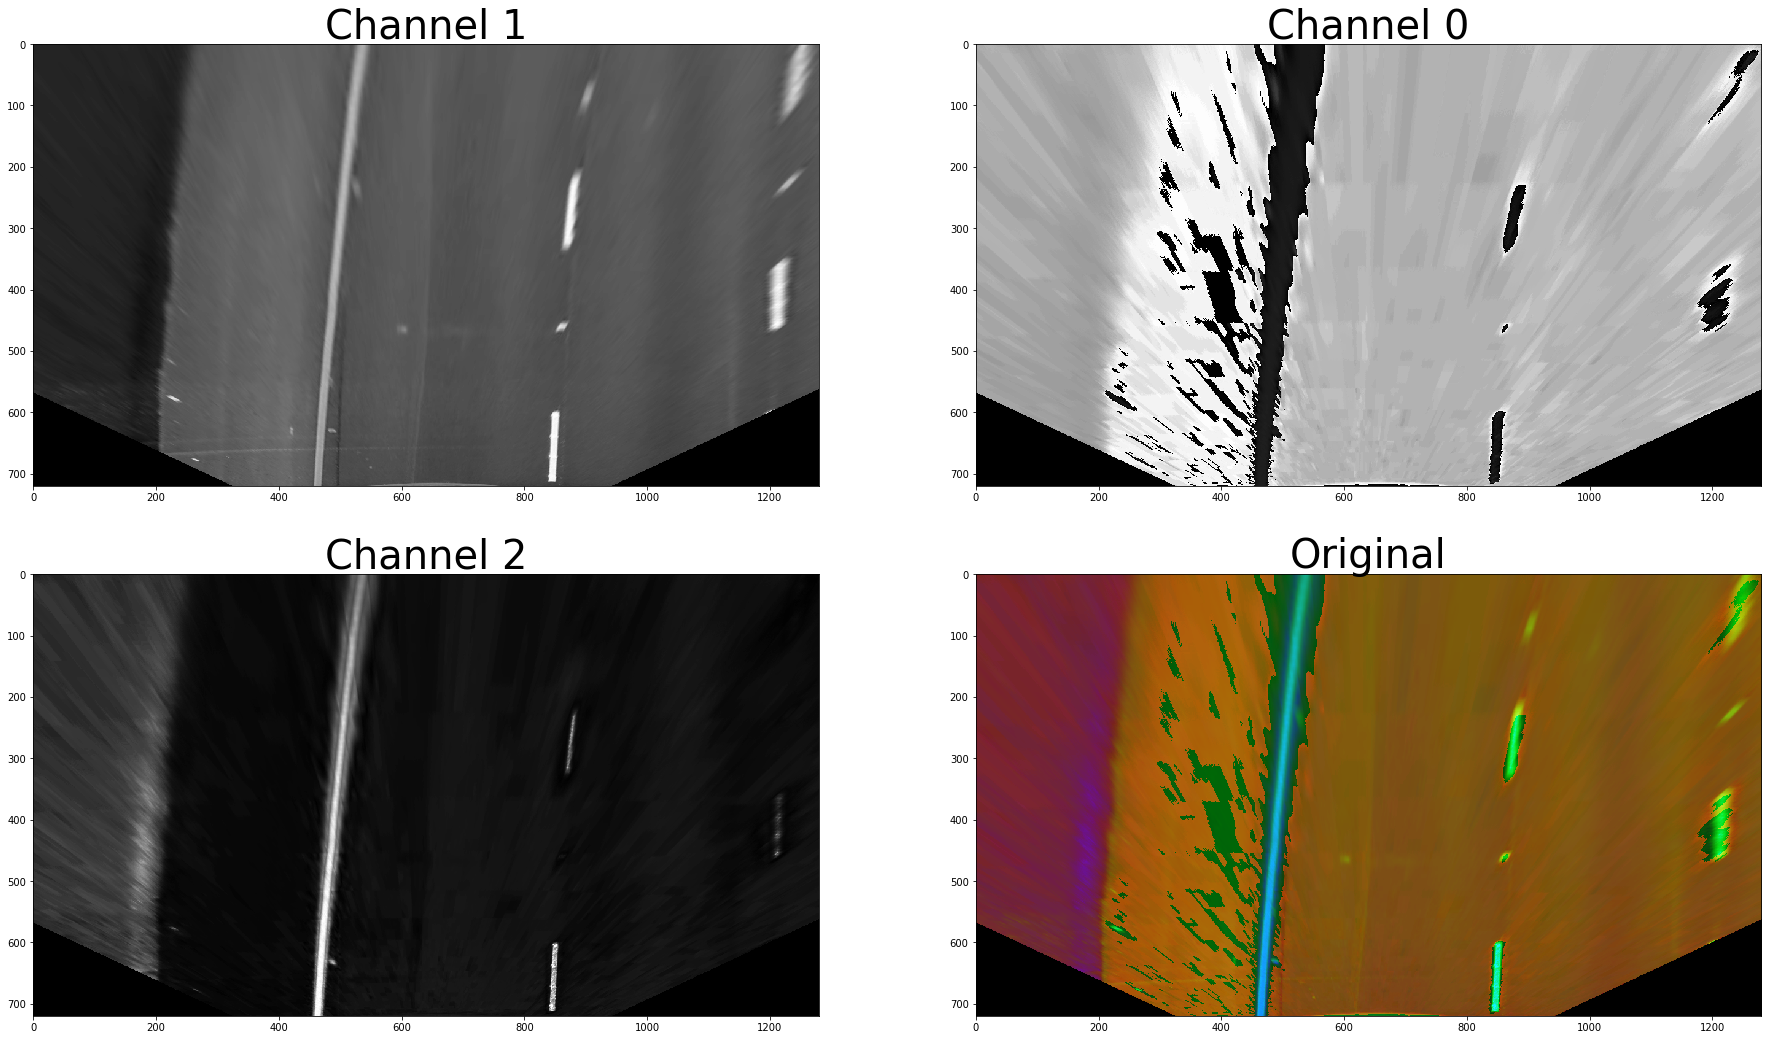

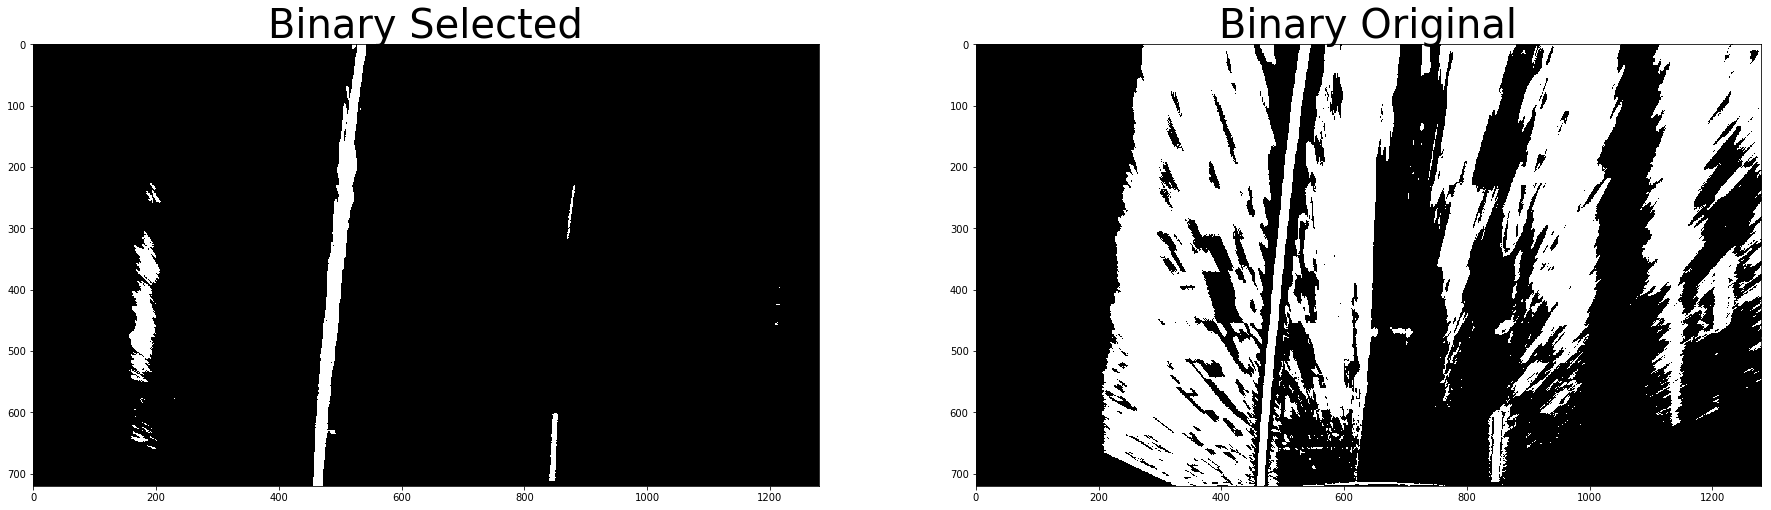

In [18]:
binary_s = inspect_color_space(warped_map['Undistorted and Warped Image'], threshold=(90, 255), conversion=cv2.COLOR_BGR2HLS, selected_channel=2)

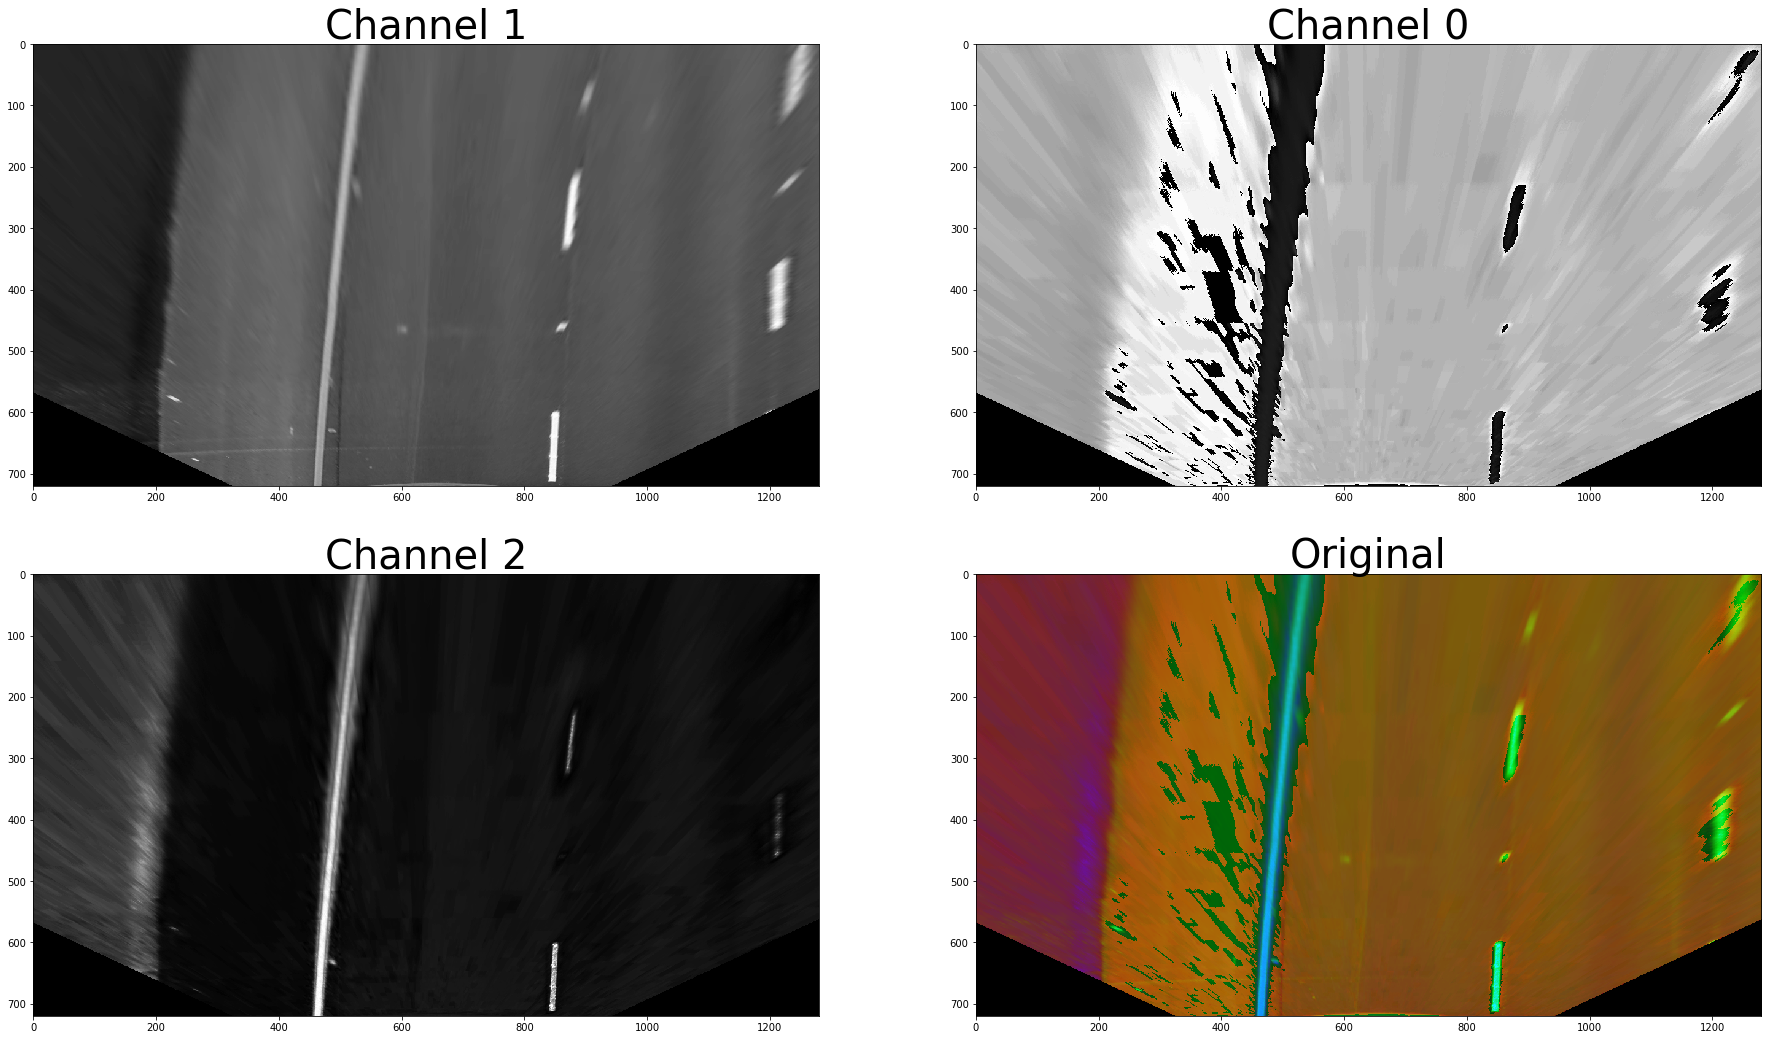

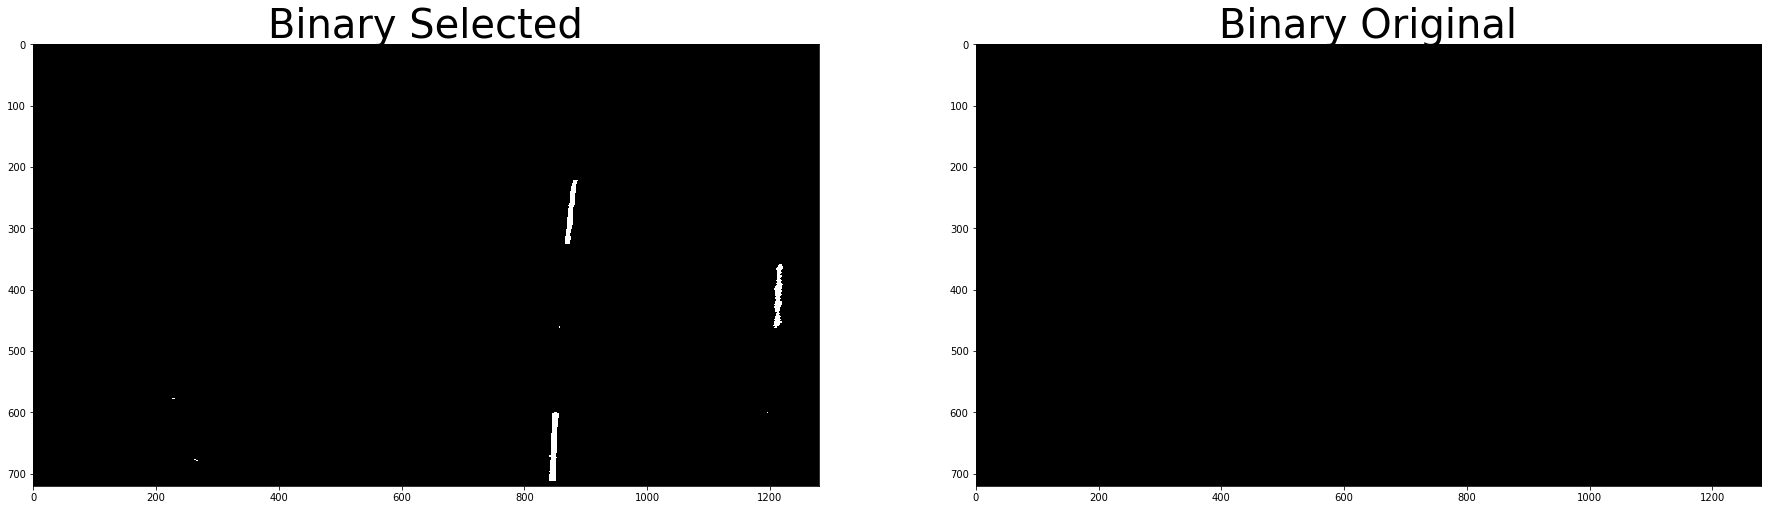

In [19]:
binary_l = inspect_color_space(warped_map['Undistorted and Warped Image'], threshold=(220, 255), conversion=cv2.COLOR_BGR2HLS, selected_channel=1)

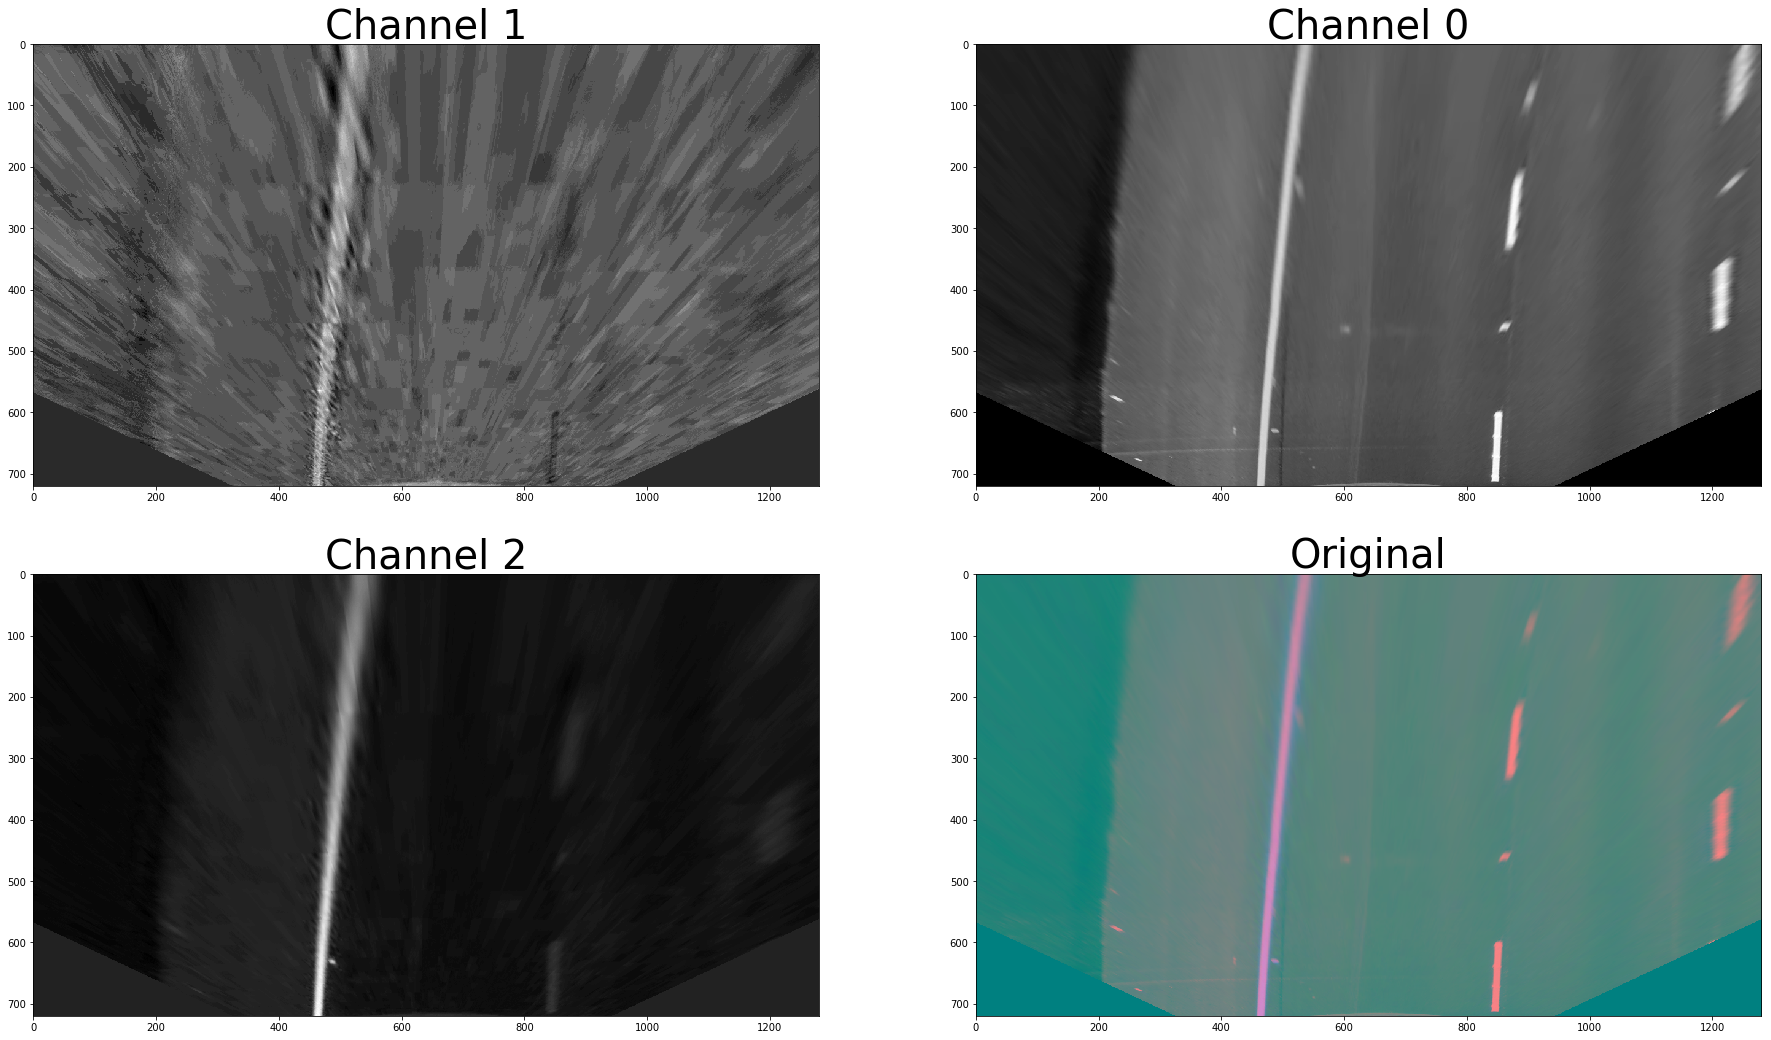

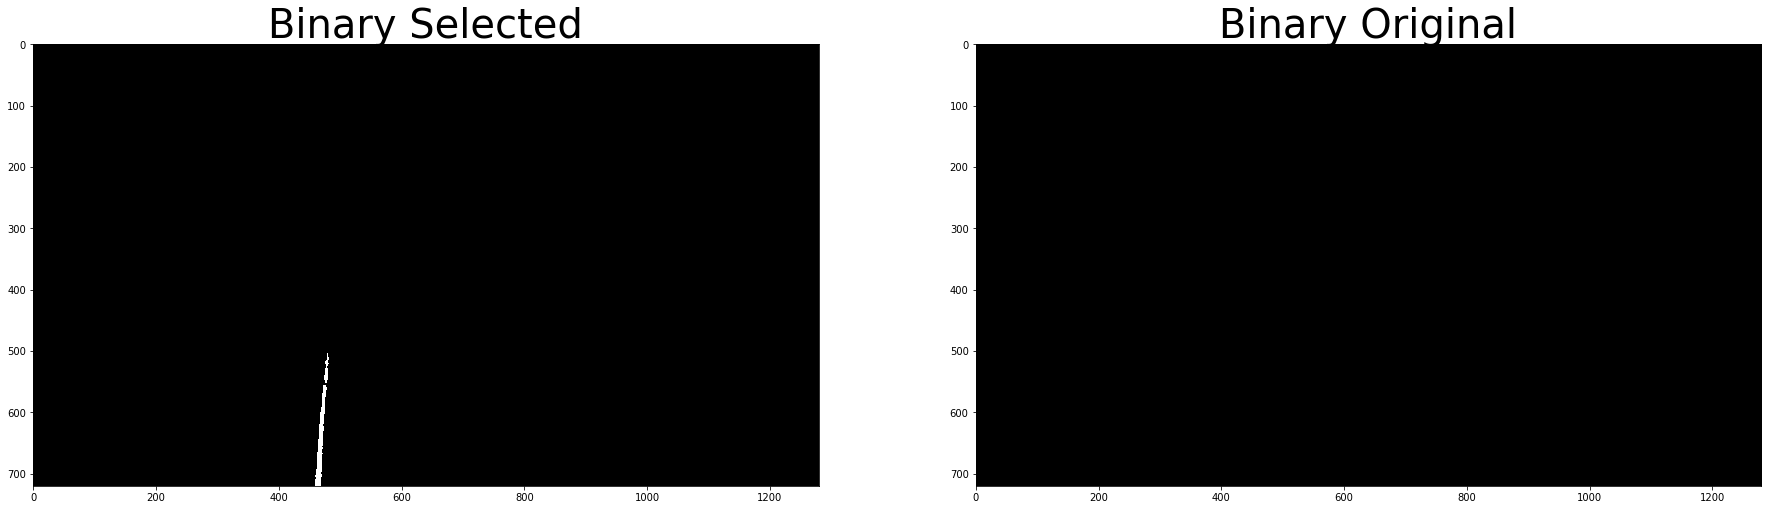

In [20]:
binary_b = inspect_color_space(warped_map['Undistorted and Warped Image'], threshold=(190,255), conversion=cv2.COLOR_BGR2Lab, selected_channel=2)

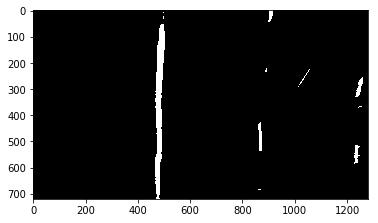

In [21]:
def apply_hls_threshold(image, thresh=(220, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    
    hls_l = hls_l*(255/np.max(hls_l))
    
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    return binary_output


def apply_lab_thresh(image, thresh=(190,255)):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
        
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output

def image_pipeline(image):
    top_down, undistorted_image, Minv = warp(image, src, dst)
    # HLS L-channel Threshold (using default parameters)
    img_LThresh = apply_hls_threshold(top_down)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = apply_lab_thresh(top_down)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, undistorted_image, Minv

lane_image = mpimg.imread("./test_images/test4.jpg")
pipelined, _, _= image_pipeline(lane_image)
mpimg.imsave("./output_images/Threshold.jpg", pipelined, cmap='gray')
plt.imshow(pipelined, cmap='gray')

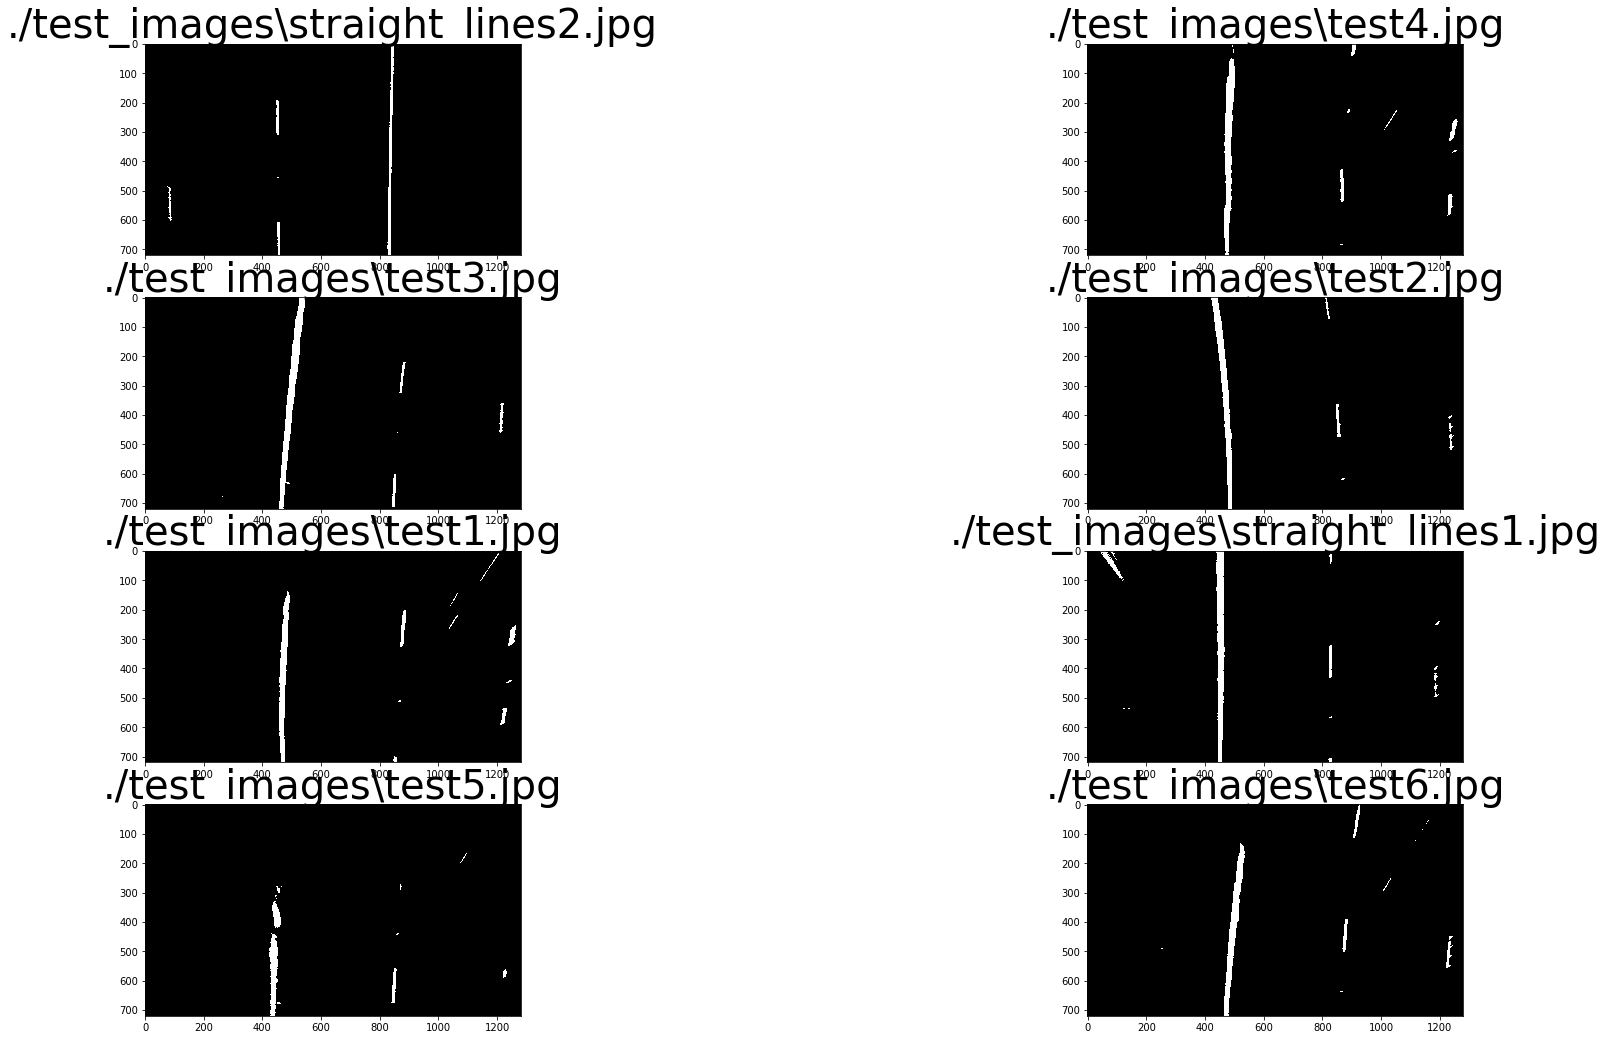

In [22]:
images = glob.glob('./test_images/*.jpg')

images_dict = {}
for image_path in images:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pipelined_image, _, _ = image_pipeline(image)
    images_dict[image_path] = pipelined_image

plot_n_images(images_dict, "gray")

In [23]:
def fit(x, y, order=2):
    result = None
    if len(x) != 0:
        result = np.polyfit(y, x, 2)
        
    return result

def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    left_fit = fit(leftx, lefty)
    right_fit = fit(rightx, righty)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

...


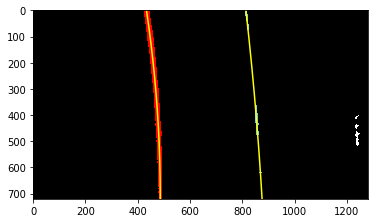

In [24]:
# visualize the result on example image
exampleImg = cv2.imread('./test_images/test2.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, _, Minv = image_pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print('...')

In [25]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 10
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new = fit(leftx, lefty)
    right_fit_new = fit(rightx, righty)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [26]:
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [27]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [28]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None: 
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [32]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, undistorted_image, Minv = image_pipeline(new_img)
    new_img = undistorted_image
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img

    return img_out

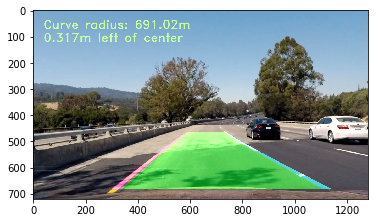

In [33]:
lane_image = mpimg.imread("./test_images/test4.jpg")
l_line = Line()
r_line = Line()

processed_image = process_image(lane_image)
mpimg.imsave("./output_images/ProcessedImage.jpg", processed_image)
plt.imshow(processed_image)

In [34]:
from moviepy.editor import VideoFileClip
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:39<00:00,  8.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 40s


In [35]:
from moviepy.editor import VideoFileClip
l_line = Line()
r_line = Line()

video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:57<00:00,  8.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 58.1 s


In [36]:
from moviepy.editor import VideoFileClip
l_line = Line()
r_line = Line()

video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:06<00:00,  6.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 3min 7s
